In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math
import random
import os

In [2]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    mask = mask.astype(int)
    return mask
mask = create_circular_mask(128,128)

In [6]:
img_path = '/home/rliu/ansim/data/data/JPEGImages/'
img_list_csv = '/home/rliu/github/ansim/img_list.csv'
train_csv = '/home/rliu/github/ansim/d200um/train200.csv'
test_csv = '/home/rliu/github/ansim/d200um/test200.csv'
img_list = pd.read_csv(img_list_csv)
seq_list = pd.read_csv(train_csv)
img_name = os.path.join(img_path, img_list.iloc[1, 0])
image = Image.open(img_name)
image = image.convert('L')
angle = 360 * np.random.uniform(0, 1)
image_resized = torchvision.transforms.functional.resize(image, (128,128), interpolation=2)
image_resized = torchvision.transforms.functional.rotate(image_resized, angle, resample=False, expand=False, center=None)
image_resized = image_resized * mask
image_resized = image_resized / 255 * math.pi
image_qxx = np.power(np.cos(image_resized),2) - 1/2
image_qxy = np.cos(image_resized) * np.sin(image_resized)
image_tensor = torch.from_numpy(image_resized)

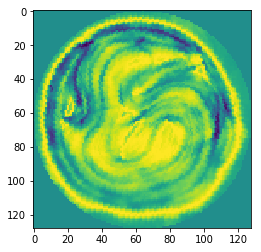

In [11]:
plt.imshow(image_qxy)

In [5]:
image_qxx = np.power(np.cos(image_resized),2)-1/2
image_qxy = np.cos(image_resized) * np.sin(image_resized)

In [47]:
class ansimDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,img_list_csv, seq_csv, root_dir, step=20, random_rotate = True, mask = mask, transform=None):
        """
        Args:
            image_csv (string): Path to the csv file with image path.
            seq_csv (string): Path to the csv file with indices of heads of sequence.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_list = pd.read_csv(img_list_csv)
        self.seq_list = pd.read_csv(seq_csv)
        self.root_dir = root_dir
        self.transform = transform
        self.step = step
        self.random_rotate = random_rotate
        self.mask = mask

    def __len__(self):
        return len(self.seq_list)

    def __getitem__(self, idx):
        seq_head = self.seq_list.iloc[idx,0]
        seq = torch.empty(self.step, 2, 128,128, dtype=torch.float)
        angle = 360 * np.random.uniform(0, 1)
        for i in np.arange(self.step):
            img_idx = seq_head + i
            img_name = os.path.join(self.root_dir, self.img_list.iloc[img_idx, 0])
            image = Image.open(img_name)
            image = image.convert('L')
            image_resized = torchvision.transforms.functional.resize(image, (128,128), interpolation=2)
            if self.random_rotate:
                image_resized = torchvision.transforms.functional.rotate(image_resized, angle, resample=False, expand=False, center=None)
            image_resized = image_resized * self.mask
            image_qxx = np.power(np.cos(image_resized),2) - 1/2
            image_qxy = np.cos(image_resized) * np.sin(image_resized)
            image_tensor_qxx = torch.from_numpy(image_qxx)
            image_tensor_qxy = torch.from_numpy(image_qxy)
            seq[i][0] = image_tensor_qxx
            seq[i][1] = image_tensor_qxy
            print(seq.size())
        if self.transform:
            seq = self.transform(seq)
        return seq

In [48]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3019],
                             std=[0.1909])
    ])

In [49]:
img_path = '/home/rliu/ansim/data/data/JPEGImages/'
img_list_csv = '/home/rliu/github/ansim/img_list.csv'
train_csv = '/home/rliu/github/ansim/d200um/train200.csv'
test_csv = '/home/rliu/github/ansim/d200um/test200.csv'
ansim_dataset = ansimDataset(img_list_csv = img_list_csv, seq_csv = train_csv, root_dir = img_path, step=20, random_rotate = True, mask = mask, transform=None)
dataset_loader = torch.utils.data.DataLoader(ansim_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=4)

In [50]:
dataiter = iter(dataset_loader)
images = dataiter.next()

torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size

torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size

torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size

torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size

torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size

torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size([20, 2, 128, 128])
torch.Size

In [27]:
images.shape[1]

NameError: name 'images' is not defined

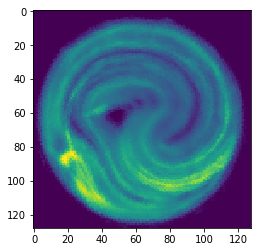

In [41]:
plt.imshow(inputs[0][1][0].numpy())

In [23]:
(inputs, target) = torch.split(images, int(images.shape[1]/2), dim=1)

In [24]:
inputs.shape[1]

10

In [9]:
def imshow(img):
    img = img * 0.1909 + 0.3019     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [10]:
dataiter = iter(dataset_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
classes = ["pos","neg","pos_o","nuc","non"]
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))
print(labels)

ValueError: too many values to unpack (expected 2)

In [20]:
train = np.zeros(3600)
test  = np.zeros(900)

In [21]:
for i in np.arange(400):
    train[i] = 1 + 10*i

for i in np.arange(400):
    train[400+i] = 5001 + 10*i
    
for i in np.arange(400):
    train[400+400+i] = 10001 + 10*i

for i in np.arange(400):
    train[400+400+400+i] = 15001 + 10*i
    
for i in np.arange(400):
    train[400+400+400+400+i] = 20001 + 10*i
    
for i in np.arange(400):
    train[400+400+400+400+400+i] = 25001 + 10*i
    
for i in np.arange(400):
    train[400+400+400+400+400+400+i] = 30001 + 10*i
    
for i in np.arange(400):
    train[400+400+400+400+400+400+400+i] = 35001 + 10*i
    
for i in np.arange(400):
    train[400+400+400+400+400+400+400+400+i] = 40001 + 10*i

In [22]:
for i in np.arange(100):
    test[i] = 4001 + 10*i

for i in np.arange(100):
    test[100+i] = 9001 + 10*i
    
for i in np.arange(100):
    test[100+100+i] = 14001 + 10*i

for i in np.arange(100):
    test[100+100+100+i] = 19001 + 10*i
    
for i in np.arange(100):
    test[100+100+100+100+i] = 24001 + 10*i
    
for i in np.arange(100):
    test[100+100+100+100+100+i] = 29001 + 10*i
    
for i in np.arange(100):
    test[100+100+100+100+100+100+i] = 34001 + 10*i
    
for i in np.arange(100):
    test[100+100+100+100+100+100+100+i] = 39001 + 10*i
    
for i in np.arange(100):
    test[100+100+100+100+100+100+100+100+i] = 44001 + 10*i

In [23]:
train.shape, test.shape

((3600,), (900,))

In [4]:
for i in np.arange(90):
    train[i] = 112001 + 20*i
    
for i in np.arange(40):
    train[90+i] = 114236 + 20*i
    
for i in np.arange(160):
    train[90+40+i] = 115236 + 20*i
    
for i in np.arange(160):
    train[90+40+160+i] = 119236 + 20*i
    
for i in np.arange(150):
    train[90+40+160+160+i] = 123236 + 20*i

for i in np.arange(150):
    train[90+40+160+160+150+i] = 126986 + 20*i
    
for i in np.arange(150):
    train[90+40+160+160+150+150+i] = 130736 + 20*i
    
for i in np.arange(150):
    train[90+40+160+160+150+150+150+i] = 134486 + 20*i

In [5]:
for i in np.arange(21):
    test[i] = 113816 + 20*i
    
for i in np.arange(10):
    test[21+i] = 115036 + 20*i
    
for i in np.arange(40):
    test[21+10+i] = 118436 + 20*i
    
for i in np.arange(40):
    test[21+10+40+i] = 112436 + 20*i
    
for i in np.arange(37):
    test[21+10+40+40+i] = 126246 + 20*i

for i in np.arange(37):
    test[21+10+40+40+37+i] = 129996 + 20*i

for i in np.arange(37):
    test[21+10+40+40+37+37+i] = 133746 + 20*i
    
for i in np.arange(37):
    test[21+10+40+40+37+37+37+i] = 137496 + 20*i

In [24]:
df_train = pd.DataFrame(train)
df_train = df_train.astype(int)
df_test = pd.DataFrame(test)
df_test = df_test.astype(int)

In [26]:
df_train[0].to_csv('unconfined/train_unconf.csv',header=False,index=False)
df_test.to_csv('unconfined/test_unconf.csv',header=False,index=False)

In [10]:
df_test

,0
0,113816
1,113836
2,113856
3,113876
4,113896
5,113916
6,113936
7,113956
8,113976
9,113996


In [27]:
df_img_list = pd.DataFrame([["%0.6d.jpg" % (x+1)] for x in range(45000)], columns=['image path'])
df_img_list.to_csv('unconfined/img_list.csv',header=False,index=False)

In [28]:
df_img_list.head(10)

,image path
0,000001.jpg
1,000002.jpg
2,000003.jpg
3,000004.jpg
4,000005.jpg
5,000006.jpg
6,000007.jpg
7,000008.jpg
8,000009.jpg
9,000010.jpg


In [ ]:
np.arange()